In [1]:
from data_common.notebook import *
import pandas as pd
from uk_ruc.create_la_data import create_la_data, get_la_with_leagues
from data_common.pandas.df_extensions.space import SpacePDAccessor as SpaceDataFrame

In [2]:
df = create_la_data()

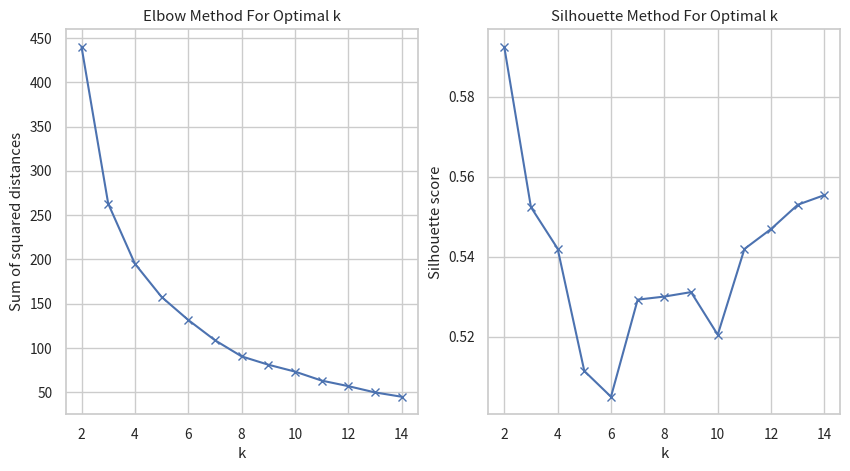

In [3]:
# now look to see if obvious clusters

c = SpaceDataFrame(df).cluster()
c.find_k()

Not *great* clustering behaviour here (to be expected, more of a spectrum). Instead lets work backwards, we want a fairly basic breakdown, so lets pick 4.

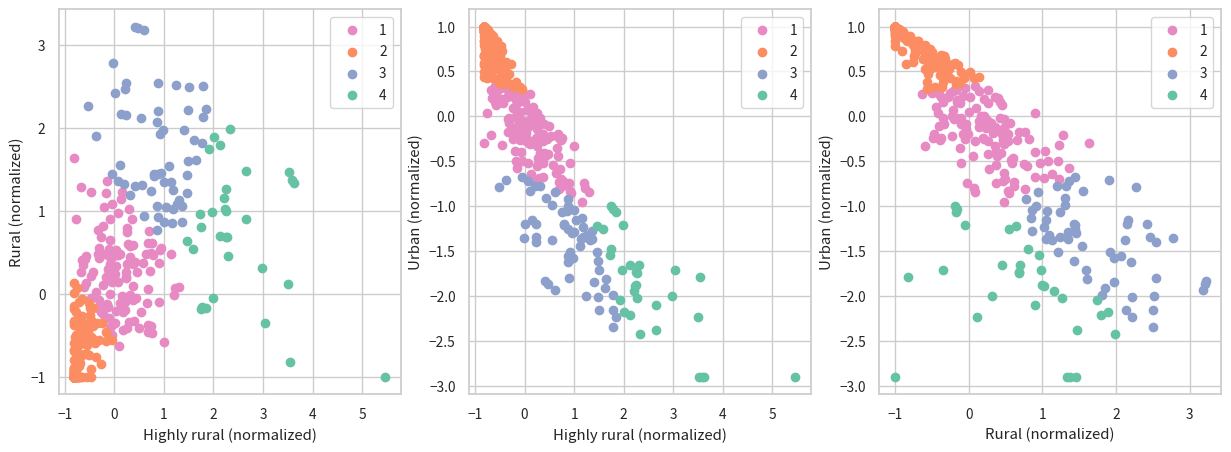

In [4]:
c.set_k(4).plot()

These seem ok grouping (although obviously at the margins the limit is not hard). 

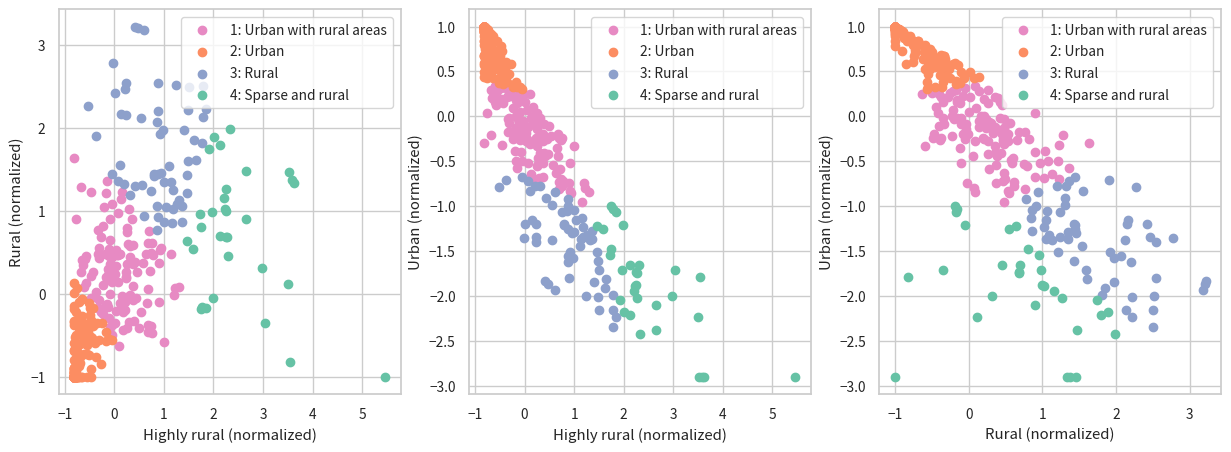

,count,%,random members
labels,,,
1: Urban with rural areas,124,30.3,"[FLN, MON, VGL, ANS, GRT]"
2: Urban,196,47.9,"[TOB, HAL, WYCA, NTY, SGC]"
3: Rural,58,14.2,"[HOR, SOX, STR, SDE, EDE]"
4: Sparse and rural,31,7.6,"[PKN, NMD, DGY, BRE, FMO]"


In [5]:
c = (
    c.set_k(4)
    .set_anchor(Path("data", "interim", "ruc_anchor.csv"))
    .add_labels(
        {2: "Urban", 4: "Sparse and rural", 1: "Urban with rural areas", 3: "Rural"}
    )
)
# c.store_anchor(Path("data", "interim", "ruc_anchor.csv"))
c.plot()
c.stats()

Assignment of leagues to groups for basic double check

In [6]:
df["cluster"] = c.label_array(include_short=False)

ldf = get_la_with_leagues().set_index("local-authority-code")
ldf = ldf.join(df, how="outer")

ldf.reset_index().pivot_table(
    "local-authority-code", index="league-group", columns="cluster", aggfunc="count"
).fillna(0)

cluster,Rural,Sparse and rural,Urban,Urban with rural areas
league-group,,,,
Combined/strategic authorities,0.0,0.0,8.0,3.0
County councils,5.0,0.0,2.0,17.0
District councils,41.0,12.0,63.0,65.0
Northern Ireland,0.0,5.0,1.0,5.0
Single tier,12.0,14.0,122.0,34.0


In [7]:
# render out the final copy

df["label"] = c.label_array(include_short=False)
final = df.reset_index()[["local-authority-code", "label"]].rename(
    columns={"label": "ruc-cluster-label"}
)
final.to_csv(Path("data", "interim", "ruc_cluster.csv"), index=False)